In [1]:
# Import dependencies
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from joblib import dump

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd

import seaborn as sns 
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

import nltk

In [17]:
# Read in CSV File
wine_data=pd.read_csv('db/wine_library.csv', dtype={'Zip': 'str'})
wine_data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


# Get the occurence of the most frequent words

In [2]:
# set seaborn style 
sns.set(style="whitegrid")

In [3]:
stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

In [5]:
def clean_description(desc):
# convert to lower cases
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

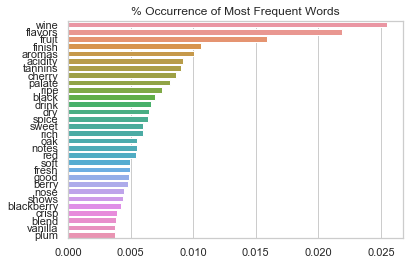

In [9]:
# Use apply method to for cleaned description for the description column
wine_data["cleaned_description"] = wine_data["description"].apply(clean_description)

word_occurrence = wine_data["cleaned_description"].str.split(expand=True).stack().value_counts()

total_words = sum(word_occurrence)

# plot most common words 
top_words = word_occurrence[:30]/total_words

# assign x and y on the plot
ax = sns.barplot(x = top_words.values, y = top_words.index)

# Setting the title to the graoh
ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

# Map the reviews by points into classes for ML

In [18]:
# defining function to get the points into buckets 
# NOTE: refere to this article (classification) https://www.winemag.com/2019/01/02/wine-vintage-chart-2019/
def buckets(points):
    if points in range(80,85): 
        return 4
    elif points in range(85,90):
        return 3
    elif points in range(90,95):
        return 2
    else:
        return 1

# Apply method to get an additional column with points in the buckets => labels
wine_data["labels"] = wine_data["points"].apply(buckets)
wine_data.head(100)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,labels
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1
5,5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,1
6,6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,NaN,Tinta de Toro,Maurodos,1
7,7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,1
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,1
